# RATIO 2019 - Benchmarking Workshop

https://gluon-nlp.mxnet.io/install.html

```
pip install --upgrade 'mxnet>=1.3.0'
pip install gluonnlp
wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip
unzip sentence_embedding.zip
ln -s sentence_embedding/bert bert
```

In [1]:
import datetime
import logging
import os
import random
import time
import warnings

import csv
import gluonnlp as nlp
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import pandas as pd
import seaborn as sns

from bert import *
from gluonnlp.data import BERTSentenceTransform
from mxnet import gluon
from mxnet.gluon.data import Dataset, SimpleDataset
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score)
from sklearn.model_selection import train_test_split
from sklearn import utils
from tqdm import tqdm

In [2]:
warnings.filterwarnings('ignore')

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)

In [3]:
# set repeatable random state
np.random.seed(100)
random.seed(100)
mx.random.seed(10000)

In [4]:
# apply progress bars for pandas .apply() -> .progress_apply()
tqdm.pandas()

In [5]:
class Timer:
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.time_start = time.time()

    def __exit__(self, *exc):
        time_end = time.time()
        time_delta = datetime.timedelta(seconds=(time_end - self.time_start))
        if self.name:
            print(("Time for [{}]: {}".format(self.name, time_delta)))
        else:
            print(("Time: {}".format(time_delta)))

# Task 1 - Same Side Classification

In [6]:
data_cross_path = 'data/same-side-classification/cross-topic/{}.csv'
data_within_path = 'data/same-side-classification/within-topic/{}.csv'

### Load within-topics and cross-topics data

In [7]:
# escapechar to detect quoting escapes, else it fails

# na_filter=False, because pandas automatic "nan" detection fails with the topic column, too
# cross_test_df['topic'].astype(str)[9270]

# within has "is_same_side" as string (boolean after latest update)
# cross has "is_same_side" as boolean (auto cast?)

with Timer("read cross"):
    # cross_traindev_df = pd.read_csv(data_cross_path.format('training'), index_col='id', escapechar='\\', na_filter=False)
    # cross_test_df = pd.read_csv(data_cross_path.format('test'), index_col='id', escapechar='\\', na_filter=False)
    cross_traindev_df = pd.read_csv(data_cross_path.format('training'),
                                    quotechar='"',
                                    quoting=csv.QUOTE_ALL,
                                    encoding='utf-8',
                                    escapechar='\\',
                                    doublequote=False,
                                    index_col='id')
    cross_test_df = pd.read_csv(data_cross_path.format('test'),
                                quotechar='"',
                                quoting=csv.QUOTE_ALL,
                                encoding='utf-8',
                                escapechar='\\',
                                doublequote=False,
                                index_col='id')

with Timer("read within"):
    # within_traindev_df = pd.read_csv(data_within_path.format('training'), index_col='id', escapechar='\\', na_filter=False)
    # within_test_df = pd.read_csv(data_within_path.format('test'), index_col='id', escapechar='\\', na_filter=False)
    within_traindev_df = pd.read_csv(data_within_path.format('training'),
                                     quotechar='"',
                                     quoting=csv.QUOTE_ALL,
                                     encoding='utf-8',
                                     escapechar='\\',
                                     doublequote=False,
                                     index_col='id')
    within_test_df = pd.read_csv(data_within_path.format('test'),
                                 quotechar='"',
                                 quoting=csv.QUOTE_ALL,
                                 encoding='utf-8',
                                 escapechar='\\',
                                 doublequote=False,
                                 index_col='id')

Time for [read cross]: 0:00:01.070654
Time for [read within]: 0:00:01.147257


In [8]:
# Adding a tag for the topics in focus: "gay marriage" and "abortion"
def add_tag(row):
    title = row['topic'].lower().strip()
    if "abortion" in title:
        row['tag'] = 'abortion'
    elif "gay marriage"  in title:
        row['tag'] = 'gay marriage'
    else:
        row['tag'] = 'NA'
    return row


with Timer("tag cross traindev"):
    cross_traindev_df = cross_traindev_df.apply(add_tag, axis=1)
with Timer("tag cross test"):
    cross_test_df = cross_test_df.apply(add_tag, axis=1)

with Timer("tag within traindev"):
    within_traindev_df = within_traindev_df.apply(add_tag, axis=1)
with Timer("tag within test"):
    within_test_df = within_test_df.apply(add_tag, axis=1)

Time for [tag cross traindev]: 0:00:32.024033
Time for [tag cross test]: 0:00:17.946527
Time for [tag within traindev]: 0:00:33.609639
Time for [tag within test]: 0:00:16.508548


## Train model - Baseline

### train dev set - 70% 30%

In [9]:
def get_train_test_sets(df, ratio=0.30, random_state=1):
    X = df[['argument1', 'argument2', 'argument1_id', 'argument2_id', 'topic', 'tag']]
    y = df[['is_same_side']]

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=ratio,
                                                        random_state=random_state,
                                                        shuffle=True)
    return X_train, X_test, y_train, y_test

### BERT

- https://gluon-nlp.mxnet.io/examples/sentence_embedding/bert.html

In [10]:
class AdvBERTDataset(SimpleDataset):
    def __init__(self, X, y=None):
        self._X = X
        self._y = y
        super(AdvBERTDataset, self).__init__(self._convert())

    def _convert(self):
        allsamples = list()

        if self._y is not None:
            df = self._X.merge(self._y, left_index=True, right_index=True)
            for _, row in df.iterrows():
                allsamples.append([
                    row['argument1'], row['argument2'],
                    ("1" if str(row['is_same_side']) == "True" else "0",
                     row['tag'])
                ])
        else:
            for _, row in self._X.iterrows():
                allsamples.append([row['argument1'], row['argument2'], None])

        return allsamples


class AdvBERTDatasetTransform(object):
    def __init__(self,
                 tokenizer,
                 max_seq_length,
                 labels=None,
                 labels_adv=None,
                 pad=True,
                 pair=True,
                 label_dtype='float32',
                 label_adv_dtype='float32'):
        self.label_dtype = label_dtype
        self.label_adv_dtype = label_adv_dtype
        self.labels = labels
        self.labels_adv = labels_adv
        if self.labels:
            self._label_map = {}
            for (i, label) in enumerate(labels):
                self._label_map[label] = i
        if self.labels_adv:
            self._label_adv_map = {}
            for (i, label_adv) in enumerate(labels_adv):
                self._label_adv_map[label_adv] = i
        self._bert_xform = BERTSentenceTransform(tokenizer,
                                                 max_seq_length,
                                                 pad=pad,
                                                 pair=pair)

    def __call__(self, line):
        input_ids, valid_length, segment_ids = self._bert_xform(line[:-1])

        label, label_adv = line[-1]
        if self.labels:  # for classification task
            label = self._label_map[label]
        if self.labels_adv:
            label_adv = self._label_adv_map[label_adv]
        label = np.array([label], dtype=self.label_dtype)
        label_adv = np.array([label_adv], dtype=self.label_adv_dtype)

        return input_ids, valid_length, segment_ids, (label, label_adv)

**TODO**: my own `BERTDatasetTransform` for extracting chunks from arguments or last part etc.

```python
transform = dataset.BERTDatasetTransform(bert_tokenizer, 512,
                                         labels=['0', '1'],
                                         label_dtype='int32',
                                         pad=True,
                                         pair=True)
```

http://localhost:9001/edit/bert/dataset.py @454
```python
# substitute with my own (e. g. last part, many parts etc.)
def __init__(...):
    self._bert_xform = BERTSentenceTransform(tokenizer, max_seq_length, pad=pad, pair=pair)
```
https://gluon-nlp.mxnet.io/master/_modules/gluonnlp/data/transforms.html#BERTSentenceTransform
```python
# substitute with my own (e. g. only last part (trim from start))
self._truncate_seq_pair(tokens_a, tokens_b, self._max_seq_length - 3)
```

https://mxnet.incubator.apache.org/_modules/mxnet/gluon/data/dataset.html#Dataset.transform

In [11]:
class AdvSigmoidBinaryCrossEntropyLoss(gluon.loss.SigmoidBinaryCrossEntropyLoss):
    def __init__(self, from_sigmoid=False, weight=None, batch_axis=0, **kwargs):
        super(AdvSigmoidBinaryCrossEntropyLoss, self).__init__(from_sigmoid=from_sigmoid, weight=weight, batch_axis=batch_axis, **kwargs)

    def hybrid_forward(self, F, pred, label, sample_weight=None):
        label = _reshape_like(F, label, pred)
        if not self._from_sigmoid:
            # We use the stable formula: max(x, 0) - x * z + log(1 + exp(-abs(x)))
            loss = F.relu(pred) - pred * label + F.Activation(-F.abs(pred), act_type='softrelu')
        else:
            loss = -(F.log(pred+1e-12)*label + F.log(1.-pred+1e-12)*(1.-label))
        loss = _apply_weighting(F, loss, self._weight, sample_weight)
        loss = -loss  # EK
        return F.mean(loss, axis=self._batch_axis, exclude=True)


class AdvSoftmaxCrossEntropyLoss(gluon.loss.SoftmaxCrossEntropyLoss):
    def __init__(self, axis=-1, sparse_label=True, from_logits=False, weight=None,
                 batch_axis=0, **kwargs):
        super(AdvSoftmaxCrossEntropyLoss, self).__init__(axis=axis, sparse_label=sparse_label, from_logits=from_logits, weight=weight, batch_axis=batch_axis, **kwargs)

    def hybrid_forward(self, F, pred, label, sample_weight=None):
        if not self._from_logits:
            pred = F.log_softmax(pred, self._axis)
        if self._sparse_label:
            loss = -F.pick(pred, label, axis=self._axis, keepdims=True)
        else:
            label = gluon.loss._reshape_like(F, label, pred)
            loss = -F.sum(pred*label, axis=self._axis, keepdims=True)
        loss = gluon.loss._apply_weighting(F, loss, self._weight, sample_weight)
        loss = -loss  # EK
        return F.mean(loss, axis=self._batch_axis, exclude=True)

In [12]:
from mxnet.gluon import Block
from mxnet.gluon import nn


class BERTAdversarialClassifier(Block):
    """Model for sentence (pair) classification task with BERT.

    The model feeds token ids and token type ids into BERT to get the
    pooled BERT sequence representation, then apply a Dense layer for
    classification. Does this also for an adversarial classifier.

    Parameters
    ----------
    bert: BERTModel
        Bidirectional encoder with transformer.
    num_classes : int, default is 2
        The number of target classes.
    num_classes_adv : int, default is 2
        The number of target classes for adversarial classifier.
    dropout : float or None, default 0.0.
        Dropout probability for the bert output.
    prefix : str or None
        See document of `mx.gluon.Block`.
    params : ParameterDict or None
        See document of `mx.gluon.Block`.
    """

    def __init__(self,
                 bert,
                 num_classes=2,
                 num_classes_adv=2,
                 dropout=0.0,
                 prefix=None,
                 params=None):
        super(BERTAdversarialClassifier, self).__init__(prefix=prefix, params=params)
        self.bert = bert
        with self.name_scope():
            self.classifier = nn.HybridSequential(prefix=prefix)
            if dropout:
                self.classifier.add(nn.Dropout(rate=dropout))
            self.classifier.add(nn.Dense(units=num_classes))

            self.adversarial_classifier = nn.HybridSequential(prefix=prefix)
            if dropout:
                self.adversarial_classifier.add(nn.Dropout(rate=dropout))
            self.adversarial_classifier.add(nn.Dense(units=num_classes_adv))

    def forward(self, inputs, token_types, valid_length=None):  # pylint: disable=arguments-differ
        """Generate the unnormalized scores for the given the input sequences.
        From both classifiers (classifier + adversarial_classifier).

        Parameters
        ----------
        inputs : NDArray, shape (batch_size, seq_length)
            Input words for the sequences.
        token_types : NDArray, shape (batch_size, seq_length)
            Token types for the sequences, used to indicate whether the word belongs to the
            first sentence or the second one.
        valid_length : NDArray or None, shape (batch_size)
            Valid length of the sequence. This is used to mask the padded tokens.

        Returns
        -------
        outputs : NDArray
            Shape (batch_size, num_classes), outputs of classifier.
        outputs_adv : NDArray
            Shape (batch_size, num_classes_adv), outputs of adversarial classifier.
        """
        _, pooler_out = self.bert(inputs, token_types, valid_length)
        classifier_out = self.classifier(pooler_out)
        adversarial_classifier_out = self.adversarial_classifier(pooler_out)
        return (classifier_out, adversarial_classifier_out)

In [13]:
# for chunked arguments, we may have to compute it all at once beforehand, should not be that much
# since we call with any `*BERTSentenceTransform` object, 
#    splitting the lines may have to be done before a transformation of a line?
#    -> chunking / sentence splitting, then feeding the result into the transformer, ...
from mxnet.gluon.data import Dataset, SimpleDataset


class MySimpleDataset(SimpleDataset):
    """Simple Dataset wrapper for lists and arrays.

    Parameters
    ----------
    data : dataset-like object
        Any object that implements `len()` and `[]`.
    """
    def __init__(self, data):
        self._data = data

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        return self._data[idx]
    
    def transform(self, fn, lazy=True):
        """Returns a new dataset with each sample transformed by the
        transformer function `fn`.

        Parameters
        ----------
        fn : callable
            A transformer function that takes a sample as input and
            returns the transformed sample.
        lazy : bool, default True
            If False, transforms all samples at once. Otherwise,
            transforms each sample on demand. Note that if `fn`
            is stochastic, you must set lazy to True or you will
            get the same result on all epochs.

        Returns
        -------
        Dataset
            The transformed dataset.
        """
        trans = _MyLazyTransformDataset(self, fn)
        if lazy:
            return trans
        return SimpleDataset([i for i in trans])


class _MyLazyTransformDataset(Dataset):
    """Lazily transformed dataset."""
    def __init__(self, data, fn):
        self._data = data
        self._fn = fn

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        item = self._data[idx]
        if isinstance(item, tuple):
            return self._fn(*item)
        return self._fn(item)

In [14]:
from gluonnlp.data import BERTSentenceTransform


class LastPartBERTSentenceTransform(BERTSentenceTransform):
    def __init__(self, tokenizer, max_seq_length, pad=True, pair=True):
        super(MyBERTSentenceTransform, self).__init__(tokenizer, max_seq_length, pad=pad, pair=pair)


    def _truncate_seq_pair(self, tokens_a, tokens_b, max_length):
        """Truncates a sequence pair in place to the maximum length.
        Removes from end of token list."""
        # This is a simple heuristic which will always truncate the longer sequence
        # one token at a time. This makes more sense than truncating an equal percent
        # of tokens from each, since if one sequence is very short then each token
        # that's truncated likely contains more information than a longer sequence.
        while True:
            total_length = len(tokens_a) + len(tokens_b)
            if total_length <= max_length:
                break
            if len(tokens_a) > len(tokens_b):
                tokens_a.pop(0)
            else:
                tokens_b.pop(0)


# TODO: random trim ? --> bad probably
# TODO: segment-wise, e. g. 0 for normal, 1 for tokens after normal tokens, ...

In [15]:
class LastPartBERTDatasetTransform(dataset.BERTDatasetTransform):
    def __init__(self, tokenizer, max_seq_length, labels=None, pad=True, pair=True, label_dtype='float32'):
        super(MyBERTDatasetTransform, self).__init__(tokenizer, max_seq_length, labels=labels, pad=pad, pair=pair, label_dtype=label_dtype)
        self._bert_xform = LastPartBERTSentenceTransform(tokenizer, max_seq_length, pad=pad, pair=pair)

In [16]:
def setup_bert():
    # change `ctx` to `mx.cpu()` if no GPU is available.
    ctx = mx.gpu(0)
    # ctx =  mx.gpu() if mx.context.num_gpus() else mx.cpu()
    # ctx = mx.cpu()
    
    bert_base, vocabulary = nlp.model.get_model('bert_12_768_12',
                                                 dataset_name='book_corpus_wiki_en_uncased',
                                                 pretrained=True, ctx=ctx, use_pooler=True,
                                                 use_decoder=False, use_classifier=False)
    print(bert_base)
    
    model = BERTAdversarialClassifier(bert_base, num_classes=2, num_classes_adv=2, dropout=0.1)
    # only need to initialize the classifier layer.
    model.classifier.initialize(init=mx.init.Normal(0.02), ctx=ctx)
    model.adversarial_classifier.initialize(init=mx.init.Normal(0.02), ctx=ctx)
    model.hybridize(static_alloc=True)

    # softmax cross entropy loss for classification
    loss_function = gluon.loss.SoftmaxCELoss()
    loss_function.hybridize(static_alloc=True)
    adv_loss_function = AdvSoftmaxCrossEntropyLoss()  # negative loss (?)
    # adv_loss_function = gluon.loss.SoftmaxCELoss()  # normal loss
    adv_loss_function.hybridize(static_alloc=True)

    metric = mx.metric.Accuracy()
    adv_metric = mx.metric.Accuracy()
    
    # use the vocabulary from pre-trained model for tokenization
    bert_tokenizer = nlp.data.BERTTokenizer(vocabulary, lower=True)
    # maximum sequence length
    max_len = 128  # + batch_size: 32
    # max_len = 512  # + batch_size: 6 ?
    # the labels for the two classes
    all_labels = ["0", "1"]
    all_adv_labels = ["gay marriage", "abortion"]
    # whether to transform the data as sentence pairs.
    # for single sentence classification, set pair=False
    pair = True
    # TODO: own dataset transformer
    transform = AdvBERTDatasetTransform(bert_tokenizer, max_len,
                                             labels=all_labels,
                                             labels_adv=all_adv_labels,
                                             label_dtype='int32',
                                             label_adv_dtype='int32',
                                             pad=True,
                                             pair=pair)

    return model, vocabulary, ctx, bert_tokenizer, transform, (loss_function, adv_loss_function), (metric, adv_metric), (all_labels, all_adv_labels)

In [17]:
def transform_dataset(X, y, transform):
    data_train_raw = AdvBERTDataset(X, y)
    data_train = data_train_raw.transform(transform)
    return data_train_raw, data_train


def predict_out_to_ys(all_predictions):
    y_true, y_pred = list(), list()
    y_adv_true, y_adv_pred = list(), list()
    
    for _, y_true_many, y_pred_many, y_adv_true_many, y_adv_pred_many in all_predictions:
        y_true_many = y_true_many.T[0].asnumpy()
        y_pred_many = np.argmax(y_pred_many, axis=1).asnumpy()
        y_adv_true_many = y_adv_true_many.T[0].asnumpy()
        y_adv_pred_many = np.argmax(y_adv_pred_many, axis=1).asnumpy()

        y_true.extend(list(y_true_many))
        y_pred.extend(list(y_pred_many))
        y_adv_true.extend(list(y_adv_true_many))
        y_adv_pred.extend(list(y_adv_pred_many))
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_adv_true = np.array(y_adv_true)
    y_adv_pred = np.array(y_adv_pred)
    
    return y_true, y_pred, y_adv_true, y_adv_pred

In [18]:
def train(model,
          data_train,
          ctx,
          metric,
          adv_metric,
          loss_function,
          adv_loss_function,
          batch_size=32,
          lr=5e-6,
          num_epochs=3,
          checkpoint_dir="data",
          use_checkpoints=True):
    with Timer("setup training"):
        train_sampler = nlp.data.FixedBucketSampler(lengths=[
            int(item[1])
            for item in tqdm(data_train, desc="compute sample lengths")
        ],
                                                    batch_size=batch_size,
                                                    shuffle=True)
        bert_dataloader = mx.gluon.data.DataLoader(data_train,
                                                   batch_sampler=train_sampler)

        trainer = gluon.Trainer(model.collect_params(), 'adam', {
            'learning_rate': lr,
            'epsilon': 1e-9
        })

        # collect all differentiable parameters
        # grad_req == 'null' indicates no gradients are calculated (e.g. constant parameters)
        # the gradients for these params are clipped later
        params = [
            p for p in model.collect_params().values() if p.grad_req != 'null'
        ]

    log_interval = 10
    with Timer("training"):
        stats = list()
        for epoch_id in range(num_epochs):
            if use_checkpoints:
                epoch_checkpoint_savefile = "bert.model.checkpoint{}.params".format(
                    epoch_id)
                if checkpoint_dir is not None:
                    epoch_checkpoint_savefile = os.path.join(
                        checkpoint_dir, epoch_checkpoint_savefile)
                if os.path.exists(epoch_checkpoint_savefile):
                    model.load_parameters(epoch_checkpoint_savefile, ctx=ctx)
                    print("loaded checkpoint for epoch {}".format(epoch_id))
                    continue

            with Timer("epoch {}".format(epoch_id)):
                metric.reset()
                step_loss = 0
                t_p = time.time()  # time keeping
                for batch_id, (token_ids, valid_length, segment_ids,
                               (label,
                                label_adv)) in enumerate(bert_dataloader):
                    with mx.autograd.record():

                        # load data to GPU
                        token_ids = token_ids.as_in_context(ctx)
                        valid_length = valid_length.as_in_context(ctx)
                        segment_ids = segment_ids.as_in_context(ctx)
                        label = label.as_in_context(ctx)
                        label_adv = label_adv.as_in_context(ctx)

                        # forward computation
                        (out, out_adv) = model(token_ids, segment_ids,
                                               valid_length.astype('float32'))
                        ls = loss_function(out, label).mean()
                        ls_adv = adv_loss_function(out_adv, label_adv).mean()

                    # backward computation
                    if batch_id % 2 == 1:
                        ls.backward()
                    else:
                        ls_adv.backward()

                    # gradient clipping
                    trainer.allreduce_grads()
                    nlp.utils.clip_grad_global_norm(params, 1)
                    trainer.update(1, ignore_stale_grad=True)

                    step_loss += ls.asscalar()
                    metric.update([label], [out])
                    adv_metric.update([label_adv], [out_adv])
                    stats.append((metric.get()[1], ls.asscalar(),
                                  adv_metric.get()[1], ls_adv.asscalar()))
                    if (batch_id + 1) % (log_interval) == 0:
                        print(
                            '[Epoch {} Batch {}/{}] loss={:.4f}, lr={:.7f}, acc={:.3f}, acc_adv={:.3f} - time {}'
                            .format(
                                epoch_id, batch_id + 1, len(bert_dataloader),
                                step_loss / log_interval,
                                trainer.learning_rate,
                                metric.get()[1],
                                adv_metric.get()[1],
                                datetime.timedelta(seconds=(time.time() -
                                                            t_p))))
                        t_p = time.time()
                        step_loss = 0

            if use_checkpoints:
                model.save_parameters(epoch_checkpoint_savefile)

    return stats

In [19]:
def predict(model, data_predict, ctx, metric, adv_metric, loss_function, adv_loss_function, batch_size=32):
    bert_dataloader = mx.gluon.data.DataLoader(data_predict, batch_size=batch_size)
    
    all_predictions = list()

    with Timer("prediction"):
        metric.reset()
        cum_loss = 0
        cum_loss_adv = 0
        for batch_id, (token_ids, valid_length, segment_ids,
                       (label, label_adv)) in enumerate(tqdm(bert_dataloader)):
            # load data to GPU
            token_ids = token_ids.as_in_context(ctx)
            valid_length = valid_length.as_in_context(ctx)
            segment_ids = segment_ids.as_in_context(ctx)
            label = label.as_in_context(ctx)
            label_adv = label_adv.as_in_context(ctx)

            # forward computation
            (out, out_adv) = model(token_ids, segment_ids,
                        valid_length.astype('float32'))
            ls = loss_function(out, label).mean()
            ls_adv = adv_loss_function(out_adv, label_adv).mean()

            metric.update([label], [out])
            adv_metric.update([label_adv], [out_adv])
            cum_loss += ls.asscalar()  # .sum() ?
            cum_loss_adv += ls_adv.asscalar()
            all_predictions.append((batch_id, label, out, label_adv, out_adv))
            
    return all_predictions, cum_loss, cum_loss_adv

In [20]:
def print_infos(vocabulary, data_train_raw, data_train):
    sample_id = 0

    # sentence a
    print(data_train_raw[sample_id][0])
    # sentence b
    print(data_train_raw[sample_id][1])
    # 1 means equivalent, 0 means not equivalent
    print(data_train_raw[sample_id][2])

    print('vocabulary used for tokenization = \n%s'%vocabulary)
    print('[PAD] token id = %s'%(vocabulary['[PAD]']))
    print('[CLS] token id = %s'%(vocabulary['[CLS]']))
    print('[SEP] token id = %s'%(vocabulary['[SEP]']))

    print('token ids = \n%s'%data_train[sample_id][0])
    print('valid length = \n%s'%data_train[sample_id][1])
    print('segment ids = \n%s'%data_train[sample_id][2])
    print('label = \n%s'%data_train[sample_id][3][0])
    print('label_adv = \n%s'%data_train[sample_id][3][1])
    

def plot_train_stats(stats):
    if not stats:
        print("no stats to plot")
        return

    x = np.arange(len(stats))  # arange/linspace

    acc_dots, loss_dots, adv_acc_dots, adv_loss_dots = zip(*stats)

    plt.subplot(4, 1, 1)
    plt.plot(x, acc_dots)  # Linie: '-', 'o-', '.-'
    plt.title('Training BERTClassifier')
    plt.ylabel('Accuracy')

    plt.subplot(4, 1, 2)
    plt.plot(x, loss_dots)
    plt.ylabel('Loss')
    
    plt.subplot(4, 1, 3)
    plt.plot(x, adv_acc_dots)  # Linie: '-', 'o-', '.-'
    plt.ylabel('Adv Accuracy')

    plt.subplot(4, 1, 4)
    plt.plot(x, adv_loss_dots)
    plt.xlabel('Batches')
    plt.ylabel('Adv Loss')

    plt.show()

### Evaluate

In [21]:
def heatconmat(y_test, y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(9, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(np.unique(y_test)))
    plt.show()


def report_training_results(y_test, y_pred, name=None, heatmap=True):
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    if heatmap:
        heatconmat(y_test, y_pred)
    print()
    print('Accuracy: ', round(accuracy_score(y_test, y_pred), 2), '\n')  #

    print('Report{}:'.format("" if not name else " for [{}]".format(name)))
    print(classification_report(y_test, y_pred))

    f1_dic = {}
    f1_dic['macro'] = round(
        f1_score(y_pred=y_pred, y_true=y_test, average='macro'), 2)
    f1_dic['micro'] = round(
        f1_score(y_pred=y_pred, y_true=y_test, average='micro'), 2)
    return f1_dic

### Within topic - Training and evaluating model 

In [22]:
# 1. Getting train and dev data
with Timer("1 - test/train split"):
    X_train, X_dev, y_train, y_dev = get_train_test_sets(within_traindev_df)

Time for [1 - test/train split]: 0:00:00.016046


In [23]:
# 2. setup
with Timer("2 - setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, (loss_function, adv_loss_function), (metric, adv_metric), (all_labels, all_adv_labels) = setup_bert()

BERTModel(
  (encoder): BERTEncoder(
    (dropout_layer): Dropout(p = 0.1, axes=())
    (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
    (transformer_cells): HybridSequential(
      (0): BERTEncoderCell(
        (dropout_layer): Dropout(p = 0.1, axes=())
        (attention_cell): MultiHeadAttentionCell(
          (_base_cell): DotProductAttentionCell(
            (_dropout_layer): Dropout(p = 0.1, axes=())
          )
          (proj_query): Dense(768 -> 768, linear)
          (proj_key): Dense(768 -> 768, linear)
          (proj_value): Dense(768 -> 768, linear)
        )
        (proj): Dense(768 -> 768, linear)
        (ffn): BERTPositionwiseFFN(
          (ffn_1): Dense(768 -> 3072, linear)
          (activation): GELU()
          (ffn_2): Dense(3072 -> 768, linear)
          (dropout_layer): Dropout(p = 0.1, axes=())
          (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
        )
        (la

In [25]:
with Timer("3 - prepare training data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    print_infos(vocabulary, data_train_raw, data_train)

wanted fetuses are beloved "babies"; unwanted ones are "tissue" (inconsistent)
abortions are emotionally and psychologically unsafe.
('1', 'abortion')
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2  2359 10768  5809  2229  2024 11419  1000 10834  1000  1025 18162
  3924  2024  1000  8153  1000  1006 20316  1007     3 11324  2015  2024
 14868  1998  8317  2135 25135  1012     3     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     

compute sample lengths: 100%|██████████| 44732/44732 [03:13<00:00, 231.30it/s]


Time for [setup training]: 0:03:13.422133
[Epoch 0 Batch 10/1401] loss=0.7195, lr=0.0000050, acc=0.456, acc_adv=0.594 - time 0:00:08.713610
[Epoch 0 Batch 20/1401] loss=0.6997, lr=0.0000050, acc=0.481, acc_adv=0.588 - time 0:00:08.076034
[Epoch 0 Batch 30/1401] loss=0.7094, lr=0.0000050, acc=0.478, acc_adv=0.597 - time 0:00:07.753233
[Epoch 0 Batch 40/1401] loss=0.7069, lr=0.0000050, acc=0.472, acc_adv=0.584 - time 0:00:07.817889
[Epoch 0 Batch 50/1401] loss=0.6885, lr=0.0000050, acc=0.484, acc_adv=0.598 - time 0:00:08.156579
[Epoch 0 Batch 60/1401] loss=0.7024, lr=0.0000050, acc=0.485, acc_adv=0.612 - time 0:00:07.920202
[Epoch 0 Batch 70/1401] loss=0.6934, lr=0.0000050, acc=0.492, acc_adv=0.612 - time 0:00:07.899866
[Epoch 0 Batch 80/1401] loss=0.6796, lr=0.0000050, acc=0.502, acc_adv=0.606 - time 0:00:08.348322
[Epoch 0 Batch 90/1401] loss=0.6889, lr=0.0000050, acc=0.508, acc_adv=0.586 - time 0:00:07.514329
[Epoch 0 Batch 100/1401] loss=0.7014, lr=0.0000050, acc=0.509, acc_adv=0.573

[Epoch 0 Batch 840/1401] loss=0.7058, lr=0.0000050, acc=0.534, acc_adv=0.113 - time 0:00:07.666386
[Epoch 0 Batch 850/1401] loss=0.6900, lr=0.0000050, acc=0.533, acc_adv=0.112 - time 0:00:08.178258
[Epoch 0 Batch 860/1401] loss=0.6843, lr=0.0000050, acc=0.534, acc_adv=0.110 - time 0:00:08.249987
[Epoch 0 Batch 870/1401] loss=0.6734, lr=0.0000050, acc=0.534, acc_adv=0.109 - time 0:00:07.978474
[Epoch 0 Batch 880/1401] loss=0.6907, lr=0.0000050, acc=0.534, acc_adv=0.108 - time 0:00:07.727830
[Epoch 0 Batch 890/1401] loss=0.6822, lr=0.0000050, acc=0.534, acc_adv=0.107 - time 0:00:08.019767
[Epoch 0 Batch 900/1401] loss=0.6757, lr=0.0000050, acc=0.534, acc_adv=0.106 - time 0:00:08.065148
[Epoch 0 Batch 910/1401] loss=0.6781, lr=0.0000050, acc=0.535, acc_adv=0.105 - time 0:00:08.159321
[Epoch 0 Batch 920/1401] loss=0.6790, lr=0.0000050, acc=0.535, acc_adv=0.104 - time 0:00:08.213051
[Epoch 0 Batch 930/1401] loss=0.6742, lr=0.0000050, acc=0.535, acc_adv=0.103 - time 0:00:08.246307
[Epoch 0 B

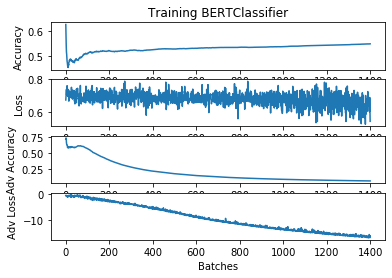

Time for [4 - train model]: 0:22:11.806224


In [27]:
with Timer("4 - train model"):
    # train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3)
    stats = train(model, data_train, ctx, metric, adv_metric, loss_function, adv_loss_function, batch_size=32, lr=5e-6, num_epochs=1)
    # model.save_parameters("data/same-side-classification/within-topic/bert.model.params")
    model.save_parameters("data/bert.model.params")

    plot_train_stats(stats)

In [26]:
with Timer("5 - prepare eval data"):
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

abortion opens the door to the sexual exploitation of women the existence of abortion gives men a little more of a safeguard against unintentionally impregnating a woman. as a result, men will be more aggressive in their sexual exploitation of women.
the fact that a child is likely to have a short life does not justify further shortening it:
('0', 'abortion')
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2 11324  7480  1996  2341  2000  1996  4424 14427  1997  2308  1996
  4598  1997 11324  3957  2273  1037  2210  2062  1997  1037 28805  2114
  4895 18447  4765 19301  2135 17727  2890 16989  3436  1037  2450  1012
  2004  1037  2765  1010  2273  2097  2022  2062  9376  1999  2037  4424
 14427  1997  2308  1012     3  1996  2755  2008  1037  2775  2003  3497
  2000  2031  1037  2460  2166  2515  2025 16114  2582  2460  7406  2009
  1024     3 

In [28]:
with Timer("6 - evaluate"):
    # model.load_parameters("data/same-side-classification/within-topic/bert.model.params", ctx=ctx)
    # model.load_parameters("data/bert.model.params", ctx=ctx)
    all_predictions, cum_loss, cum_loss_adv = predict(model, data_dev, ctx, metric, adv_metric, loss_function, adv_loss_function)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred, y_adv_true, y_adv_pred = predict_out_to_ys(all_predictions)
    report_training_results(y_true, y_pred, name="BERTClassifier - is_same_side", heatmap=False)
    report_training_results(y_adv_true, y_adv_pred, name="BERTAdvClassifier - tag", heatmap=False)

100%|██████████| 600/600 [03:07<00:00,  3.21it/s]


Time for [prediction]: 0:03:07.170824
Accuracy: 0.6237024672682698
Confusion Matrix:
[[6648 2185]
 [5029 5309]]

Accuracy:  0.62 

Report for [BERTClassifier - is_same_side]:
              precision    recall  f1-score   support

           0       0.57      0.75      0.65      8833
           1       0.71      0.51      0.60     10338

    accuracy                           0.62     19171
   macro avg       0.64      0.63      0.62     19171
weighted avg       0.64      0.62      0.62     19171

Confusion Matrix:
[[  145  6696]
 [12317    13]]

Accuracy:  0.01 

Report for [BERTAdvClassifier - tag]:
              precision    recall  f1-score   support

           0       0.01      0.02      0.02      6841
           1       0.00      0.00      0.00     12330

    accuracy                           0.01     19171
   macro avg       0.01      0.01      0.01     19171
weighted avg       0.01      0.01      0.01     19171

Time for [6 - evaluate]: 0:03:07.756662


### Train and evaluate each epoch

In [ ]:
for epoch_id in range(5):
    with Timer("4 - train model - {}".format(epoch_id)):
        stats = train(model, data_train, ctx, metric, adv_metric, loss_function, adv_loss_function, batch_size=32, lr=5e-6, num_epochs=epoch_id + 1)  # seq_len: 512
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        all_predictions, cum_loss, cum_loss_adv = predict(model, data_dev, ctx, metric, adv_metric, loss_function, adv_loss_function, batch_size=6)  # seq_len: 512
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred, y_adv_true, y_adv_pred = predict_out_to_ys(all_predictions)
        report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

    model.save_parameters("data/bert.model.params")

*may need to use **binary_cross_entrophy**?* (can I use a single label or do I have to use "0" and "1"?)

### Cross topic - Training and evaluating model 

In [ ]:
# 1. Getting train and dev data
with Timer("1 - test/train split"):
    X_train, X_dev, y_train, y_dev = get_train_test_sets(cross_traindev_df)

In [ ]:
# 2. setup
with Timer("2 - setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

In [ ]:
with Timer("3 - prepare training data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    print_infos(vocabulary, data_train_raw, data_train)

In [ ]:
with Timer("4 - train model"):
    # train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3)
    stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=2)
    # model.save_parameters("data/same-side-classification/cross-topic/bert.model.params")
    model.save_parameters("data/bert.model.params")

    plot_train_stats(stats)

In [ ]:
with Timer("5 - prepare eval data"):
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

In [ ]:
with Timer("6 - evaluate"):
    # model.load_parameters("data/same-side-classification/cross-topic/bert.model.params", ctx=ctx)
    model.load_parameters("data/bert.model.params", ctx=ctx)
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred, y_adv_true, y_adv_pred = predict_out_to_ys(all_predictions)
    report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

In [ ]:
for epoch_id in range(5):
    with Timer("4 - train model - {}".format(epoch_id)):
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=epoch_id + 1)
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred, y_adv_true, y_adv_pred = predict_out_to_ys(all_predictions)
        report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

    model.save_parameters("data/bert.model.params")